# Spatial data Preprocessing

In [14]:
import geopandas as gpd
import shapely
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 고도 데이터

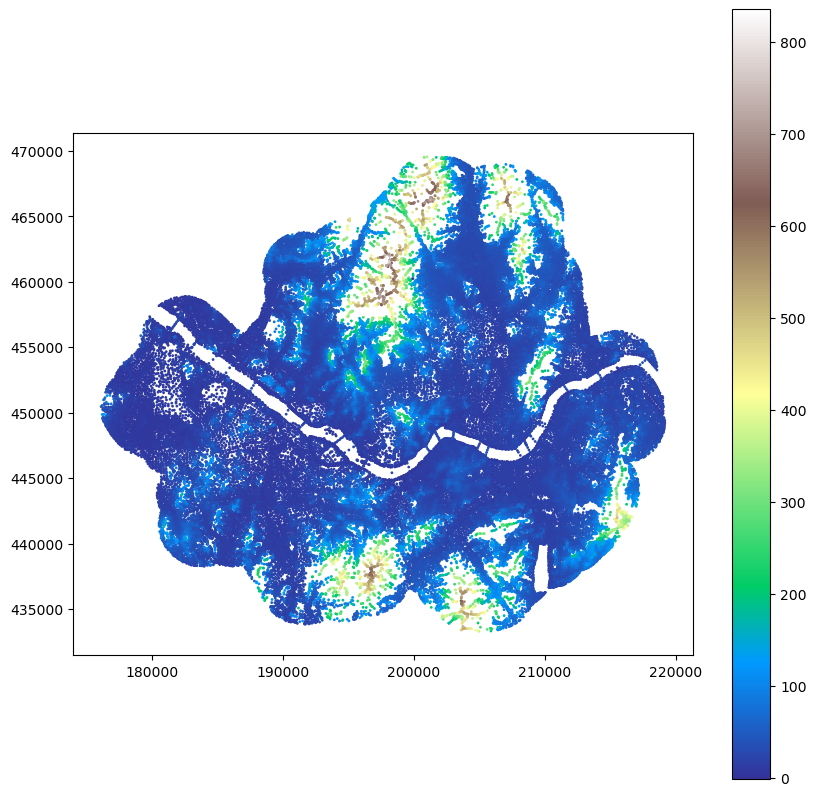

In [28]:
# Load the data
elevation = gpd.read_file('data/elevation/표고 5000/N3P_F002.shp') # crs 5174

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

elevation.plot(column='HEIGHT', ax=ax, legend=True, cmap='terrain', markersize=1)
plt.show() ## 그대로 사용하면 될듯

In [15]:
# Seoul road network (3.2s)
roads = gpd.read_file('data/seoul_road/road.shp', crs='epsg:5174')

In [16]:
# 도로종류 : 
# 광로1류 UQS111, 광로2류 UQS112, 광로3류 UQS113, 
# 대로1류 UQS114, 대로2류 UQS115, 대로3류 UQS116, 
# 중로1류 UQS117, 중로2류 UQS118, 중로3류 UQS119 UQS120, 
# 소로2류 UQS121, 소로3류 UQS122, 소로4류 UQS123, 도로시설 기타 UQS190
broads = ['UQS111', 'UQS112', 'UQS113']
mains = ['UQS114', 'UQS115', 'UQS116']
smalls = ['UQS117', 'UQS118', 'UQS119', 'UQS120']

roads_selected = roads[roads.ATRB_SE.isin(broads+mains+smalls)]

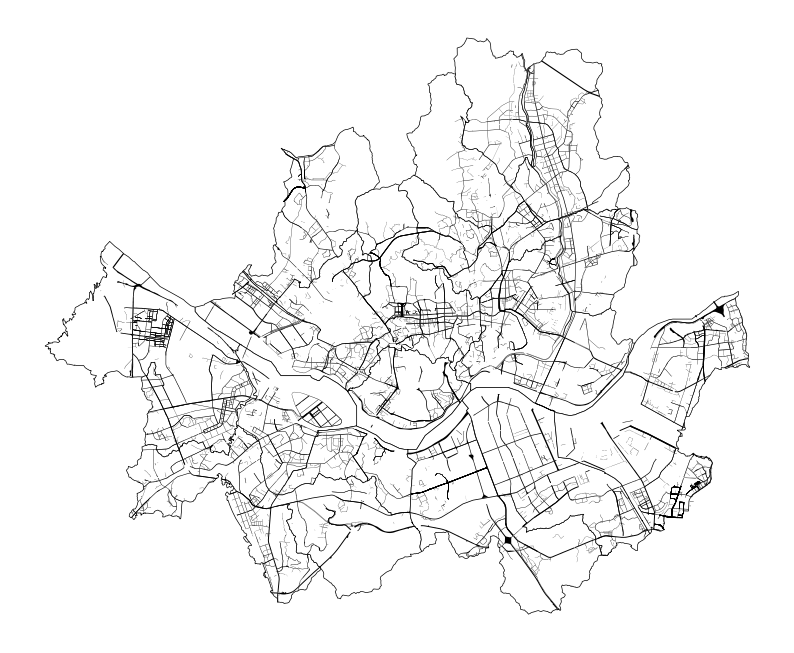

In [17]:
# 서울시 행정구역
fig, ax = plt.subplots(figsize=(10, 10))

seoul = gpd.read_file('data/seoul_geo/seoul.shp')
seoul.to_crs(epsg=5174, inplace=True)
seoul.plot(color='white', edgecolor='black', linewidth=0.5, ax=ax)
roads_selected.plot(ax=ax, color='black', linewidth=0.5)
plt.axis('off')
plt.show()

In [18]:
# 서울시 교통량 조사자료

traffic = pd.read_excel('data/traffic/04월 서울시 교통량 조사자료(2024).xlsx', sheet_name='2024년 04월')
traffic_info = pd.read_excel('data/traffic/04월 서울시 교통량 조사자료(2024).xlsx', sheet_name='수집지점 주소 및 좌표', skipfooter=4, usecols='A:E')
traffic_info = gpd.GeoDataFrame(traffic_info, geometry=gpd.points_from_xy(traffic_info['경도'], traffic_info['위도']), crs='wgs84')
traffic_info.to_crs(epsg=5174, inplace=True)

In [19]:
traffic.지점번호.nunique() # 139개 지점

139

In [20]:
# 링크 데이터

link = pd.read_excel('data/traffic/서울시 서비스링크 보간점 정보_2024년3월 기준.xlsx', engine='openpyxl')
link = gpd.GeoDataFrame(link, geometry=gpd.points_from_xy(link.GRS80TM_X, link.GRS80TM_Y), crs='epsg:5174')

In [21]:
# groupby link id and make the points to a line object
from shapely.geometry import LineString

link_line = link.groupby('LINK_ID').apply(lambda x: LineString(x['geometry'].tolist())).reset_index()
link_line.columns = ['LINK_ID', 'geometry']
link_line = gpd.GeoDataFrame(link_line, crs='epsg:5174')

/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_79713/1057496940.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  link_line = link.groupby('LINK_ID').apply(lambda x: LineString(x['geometry'].tolist())).reset_index()


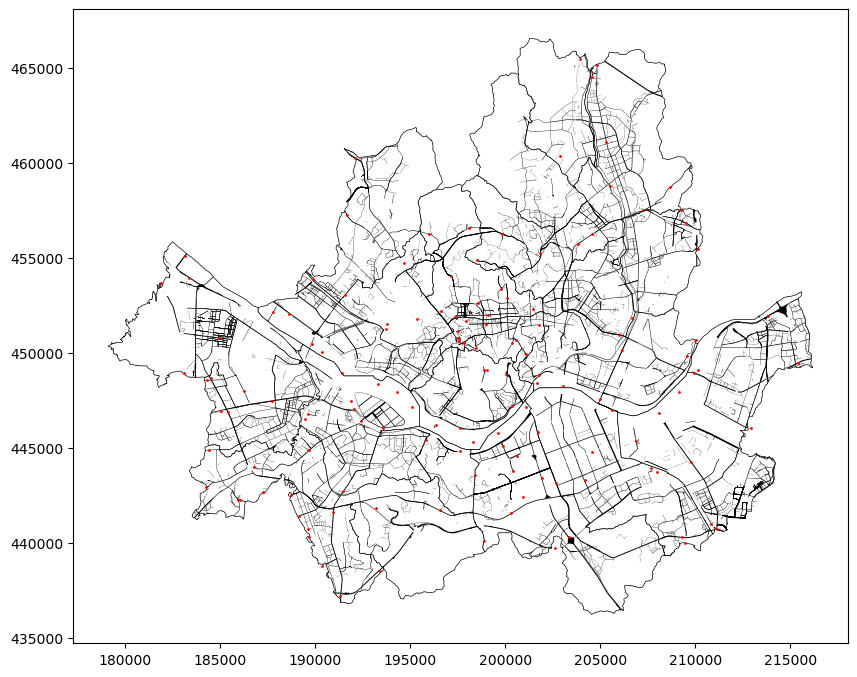

In [22]:
# 서울시 행정구역
fig, ax = plt.subplots(figsize=(10, 10))

seoul = gpd.read_file('data/seoul_geo/seoul.shp')
seoul.to_crs(epsg=5174, inplace=True)
seoul.plot(color='white', edgecolor='black', linewidth=0.5, ax=ax)
roads_selected.plot(ax=ax, color='black', linewidth=0.5)
traffic_info.plot(markersize=1, color='red', ax=ax)
plt.show()

# Using momepy

In [41]:
import momepy
import networkx as nx

# construct the road network

network = momepy.gdf_to_nx(link_line, approach='primal')

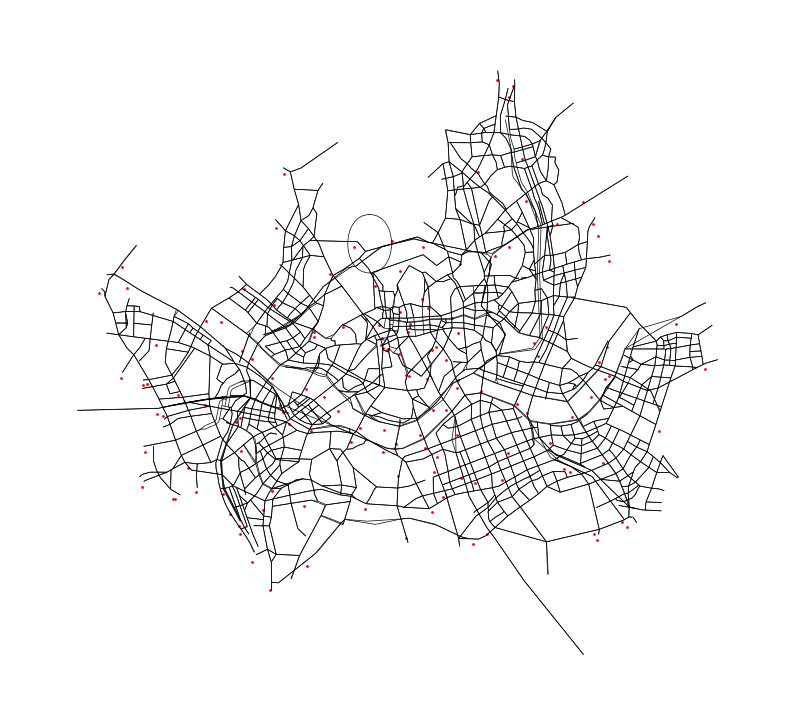

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
traffic_info.plot(markersize=1, color='red', ax=ax)
nx.draw(network, pos={node: node for node in network.nodes()}, node_size=0, edge_color='black', width=0.5, ax=ax)
plt.axis('off')
plt.show()

In [52]:
# Find the nearest link_line for each traffic_info point

traffic_info = gpd.sjoin_nearest(traffic_info, link_line, how='left')

In [57]:
traffic_info.LINK_ID.nunique() # 134개 지점 >> 5개 지점이 중복됨

134

## Shortest path

In [81]:
import spaghetti

# construct the spaghetti network (4m)
ntw = spaghetti.Network(in_data=link_line)

In [68]:
# snap the traffic_info points to the network

spaghetti_network.snapobservations(traffic_info, 'LINK_ID', 'geometry', attribute=True)

/Users/dangchan/miniforge3/envs/colab/lib/python3.10/site-packages/spaghetti/network.py:3414: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/Users/dangchan/miniforge3/envs/colab/lib/python3.10/site-packages/spaghetti/util.py:583: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
/Users/dangchan/miniforge3/envs/colab/lib/python3.10/site-packages/libpysal/cg/shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(


In [80]:
spaghetti_network.

(31281, 31281)